In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions
def create_circle_image(size, radius):
    """Create a binary circle image."""
    y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing="ij")
    center = size // 2
    mask = (x - center) ** 2 + (y - center) ** 2 <= radius ** 2
    return mask.float()

def create_square_image(size, side_length):
    """Create a binary square image."""
    img = torch.zeros((size, size))
    center = size // 2
    half_side = side_length // 2
    img[center - half_side:center + half_side, center - half_side:center + half_side] = 1.0
    return img



Epoch [50/1500], Loss: 0.1624
Epoch [100/1500], Loss: 0.1306
Epoch [150/1500], Loss: 0.1029
Epoch [200/1500], Loss: 0.0799
Epoch [250/1500], Loss: 0.0620
Epoch [300/1500], Loss: 0.0486
Epoch [350/1500], Loss: 0.0391
Epoch [400/1500], Loss: 0.0323
Epoch [450/1500], Loss: 0.0275
Epoch [500/1500], Loss: 0.0240
Epoch [550/1500], Loss: 0.0213
Epoch [600/1500], Loss: 0.0191
Epoch [650/1500], Loss: 0.0173
Epoch [700/1500], Loss: 0.0159
Epoch [750/1500], Loss: 0.0147
Epoch [800/1500], Loss: 0.0137
Epoch [850/1500], Loss: 0.0128
Epoch [900/1500], Loss: 0.0121
Epoch [950/1500], Loss: 0.0115
Epoch [1000/1500], Loss: 0.0110
Epoch [1050/1500], Loss: 0.0105
Epoch [1100/1500], Loss: 0.0101
Epoch [1150/1500], Loss: 0.0098
Epoch [1200/1500], Loss: 0.0095
Epoch [1250/1500], Loss: 0.0092
Epoch [1300/1500], Loss: 0.0089
Epoch [1350/1500], Loss: 0.0087
Epoch [1400/1500], Loss: 0.0085
Epoch [1450/1500], Loss: 0.0084
Epoch [1500/1500], Loss: 0.0082


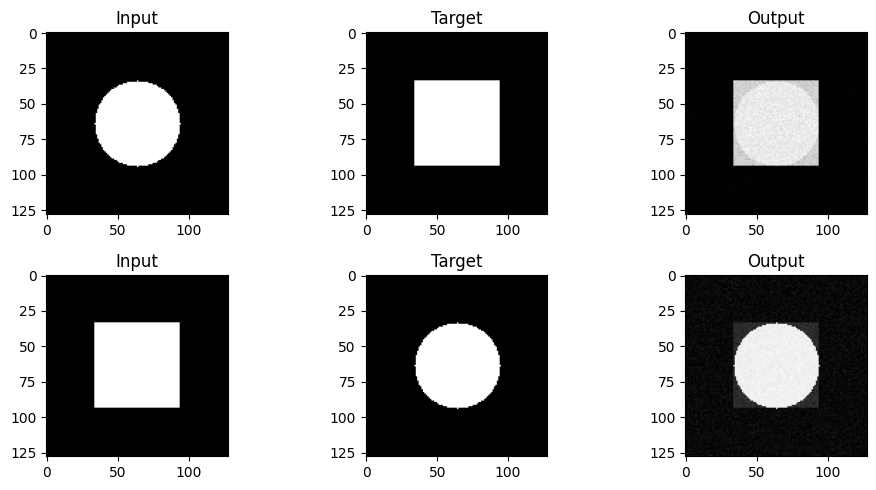

In [13]:
# Optical Layer: Phase Modulation
class PhaseLayer(nn.Module):
    def __init__(self, size):
        super(PhaseLayer, self).__init__()
        # Trainable phase values
        self.phase = nn.Parameter(torch.rand(size, size) * 2 * np.pi)

    def forward(self, field):
        # Apply phase modulation: E_out = E_in * exp(i * phase)
        return field * torch.exp(1j * self.phase)

# Propagation Function: Fresnel Diffraction
def fresnel_propagation(field, distance, wavelength, pixel_pitch):
    """Simulate Fresnel propagation of the optical field."""
    size = field.shape[-1]
    k = 2 * np.pi / wavelength  # Wave number

    # Frequency coordinates
    fx = torch.fft.fftfreq(size, d=pixel_pitch).to(field.device)
    fy = torch.fft.fftfreq(size, d=pixel_pitch).to(field.device)
    FX, FY = torch.meshgrid(fx, fy, indexing="ij")
    H = torch.exp(-1j * (np.pi * wavelength * distance) * (FX**2 + FY**2))  # Transfer function

    # Perform FFT-based Fresnel propagation
    field_fft = torch.fft.fft2(field)
    field_propagated = torch.fft.ifft2(field_fft * H)
    return field_propagated

# D^2NN Model
class DiffractiveNN(nn.Module):
    def __init__(self, num_layers, size, distance, wavelength, pixel_pitch):
        super(DiffractiveNN, self).__init__()
        self.layers = nn.ModuleList([PhaseLayer(size) for _ in range(num_layers)])
        self.distance = distance
        self.wavelength = wavelength
        self.pixel_pitch = pixel_pitch

    def forward(self, field):
        for layer in self.layers:
            field = layer(field)  # Apply phase modulation
            field = fresnel_propagation(field, self.distance, self.wavelength, self.pixel_pitch)  # Propagate
        return torch.abs(field) ** 2  # Output intensity

# Generate Training Data
size = 128  # Image size (128x128 pixels)
circle = create_circle_image(size, radius=30)
square = create_square_image(size, side_length=60)

input_images = torch.stack([circle, square])  # Input images
target_images = torch.stack([square, circle])  # Target transformations

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_images = input_images.to(device)
target_images = target_images.to(device)

num_layers = 5
distance = 20e-3  # Propagation distance in meters
wavelength = 633e-9  # Green light wavelength in meters
pixel_pitch = 8e-6  # Pixel size in meters 

model = DiffractiveNN(num_layers, size, distance, wavelength, pixel_pitch).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 1500
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(input_images)

    # Compute loss
    loss = criterion(outputs, target_images)
    losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Visualize Results
output_images = model(input_images).detach().cpu()

plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(2, 3, i * 3 + 1)
    plt.title("Input")
    plt.imshow(input_images[i].cpu().numpy(), cmap="gray")

    plt.subplot(2, 3, i * 3 + 2)
    plt.title("Target")
    plt.imshow(target_images[i].cpu().numpy(), cmap="gray")

    plt.subplot(2, 3, i * 3 + 3)
    plt.title("Output")
    plt.imshow(output_images[i].numpy(), cmap="gray")

plt.tight_layout()
plt.show()


In [12]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_images = input_images.to(device)
target_images = target_images.to(device)

num_layers = 5
distance = 20e-3  # Propagation distance in meters
wavelength = 633e-9  # Green light wavelength in meters
pixel_pitch = 8e-6  # Pixel size in meters 

model = DiffractiveNN(num_layers, size, distance, wavelength, pixel_pitch).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 1500
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(input_images)

    # Compute loss
    loss = criterion(outputs, target_images)
    losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Visualize Results
output_images = model(input_images).detach().cpu()

plt.figure(figsize=(10, 5))
for i in range(2):
    plt.subplot(2, 3, i * 3 + 1)
    plt.title("Input")
    plt.imshow(input_images[i].cpu().numpy(), cmap="gray")

    plt.subplot(2, 3, i * 3 + 2)
    plt.title("Target")
    plt.imshow(target_images[i].cpu().numpy(), cmap="gray")

    plt.subplot(2, 3, i * 3 + 3)
    plt.title("Output")
    plt.imshow(output_images[i].numpy(), cmap="gray")

plt.tight_layout()
plt.show()

RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [2, 1] but got: [2, 128].